<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/StockPrediction/blob/main/Capstone_GOOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install statsforecast keras-tuner yfinance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.4 MB/s eta 0:00:00


In [3]:
# Standard Libraries
import warnings
from datetime import datetime, timedelta

# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Finance Data
import yfinance as yf

# Statsmodels - Time Series & Statistical Tests
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera

# Scipy
from scipy.stats import t, probplot

# Forecasting Libraries
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Scikit-learn - Metrics & Preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# TensorFlow / Keras - Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Keras Tuner
import keras_tuner as kt  # You may need: pip install keras-tuner

#SVM
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


# Suppress warnings
warnings.filterwarnings("ignore")


In [4]:
# # Acquire data from yfinance

# symbol = 'GOOG'

# df = yf.download(symbol, period="max", interval="1d")
# df.to_csv("GOOG.csv")

In [5]:
GOOG = pd.read_csv("https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/GOOG.csv")
GOOG = GOOG[2:]
GOOG = GOOG.reset_index()
GOOG = GOOG.drop(columns=["index"])
GOOG = GOOG.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
GOOG[columns_to_convert] = GOOG[columns_to_convert].astype(float)
GOOG['Date'] = pd.to_datetime(GOOG['Date'])
GOOG['Volume'] = GOOG['Volume'].astype(int)
GOOG.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [6]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5186 non-null   datetime64[ns]
 1   Close   5186 non-null   float64       
 2   High    5186 non-null   float64       
 3   Low     5186 non-null   float64       
 4   Open    5186 non-null   float64       
 5   Volume  5186 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 243.2 KB


In [7]:
df = GOOG[(GOOG['Date'] >= datetime(2020, 1, 1)) & (GOOG['Date'] <= datetime(2025, 1, 31))].reset_index(drop=True)
# df = GOOG[GOOG['Date'] >= datetime.datetime(2020, 1, 1)].reset_index(drop=True)

prices = df[['Close','Date']]
prices = prices.set_index('Date')

actual = GOOG[GOOG['Date']> datetime(2025, 1, 31)].reset_index(drop=True)

In [8]:
len(actual), len(df), len(GOOG)

(39, 1278, 5186)

### EDA

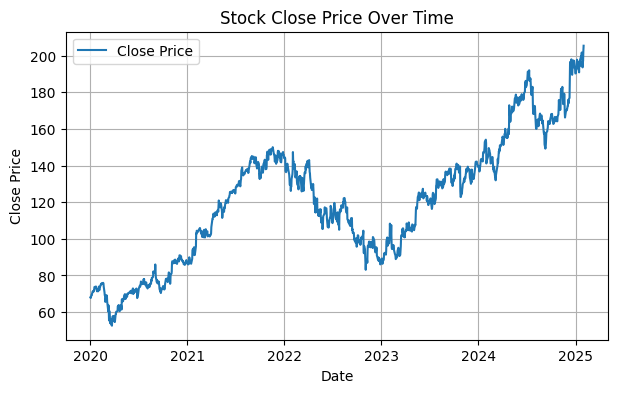

In [35]:
# Plot the Close price
plt.figure(figsize=(7, 4))
plt.plot(prices, label="Close Price")

# Chart formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### ARIMA

####Hypothesis testing:
null hypothesis: The stock is stationary

In [8]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=prices['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is -0.45
The p value is 0.90


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

Apend approach

In [28]:
modelpredictions = []

In [29]:
training_data = list(prices['Close'])

In [30]:
for i in range(len(actual)):
  model = ARIMA(training_data, order=(11,1,1))
  model_fit = model.fit()
  forecast = model_fit.forecast()
  yhat = list(forecast)[0]
  modelpredictions.append(yhat)
  actual_test = list(actual['Close'])[i]
  training_data.append(actual_test)

In [32]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1316
Model:                ARIMA(11, 1, 1)   Log Likelihood               -3009.652
Date:                Thu, 10 Apr 2025   AIC                           6045.304
Time:                        08:36:30   BIC                           6112.665
Sample:                             0   HQIC                          6070.564
                               - 1316                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6059      0.409     -1.482      0.138      -1.407       0.195
ar.L2         -0.0348      0.034     -1.031      0.302      -0.101       0.031
ar.L3         -0.0623      0.030     -2.080      0.0

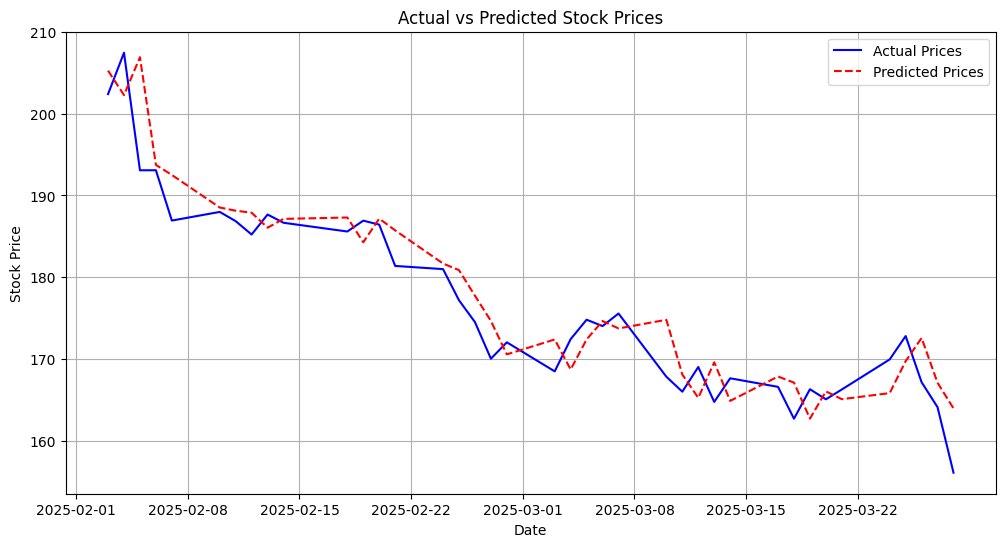

In [33]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [36]:
rmse = np.sqrt(mean_squared_error(actual['Close'], modelpredictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 4.0754


In [37]:
r2_score(actual['Close'], modelpredictions)

0.873728320419118

#### ACF - Auto Correlation Function


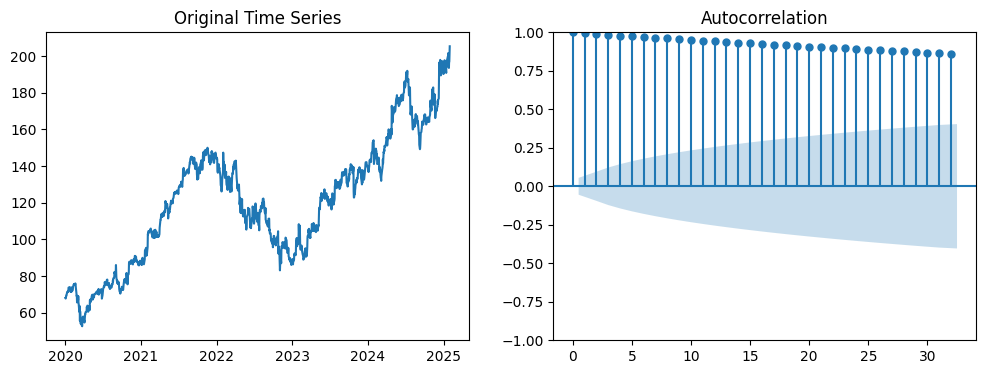

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(prices['Close'])
ax1.set_title('Original Time Series')
plot_acf(prices['Close'],ax=ax2);

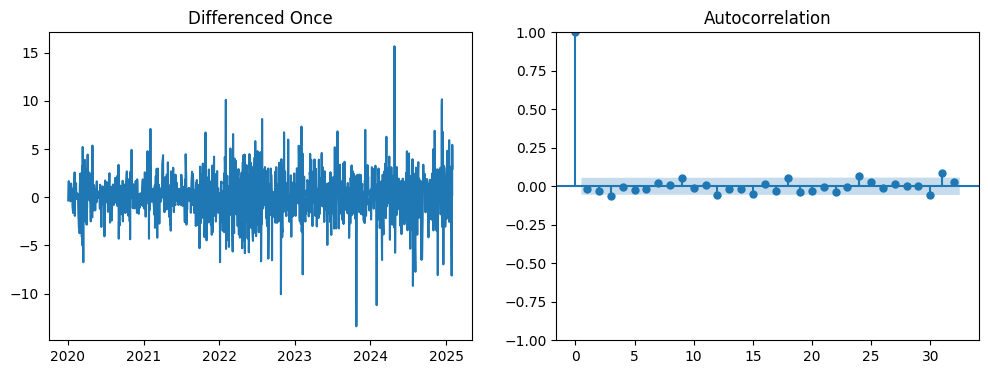

In [ ]:
diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);

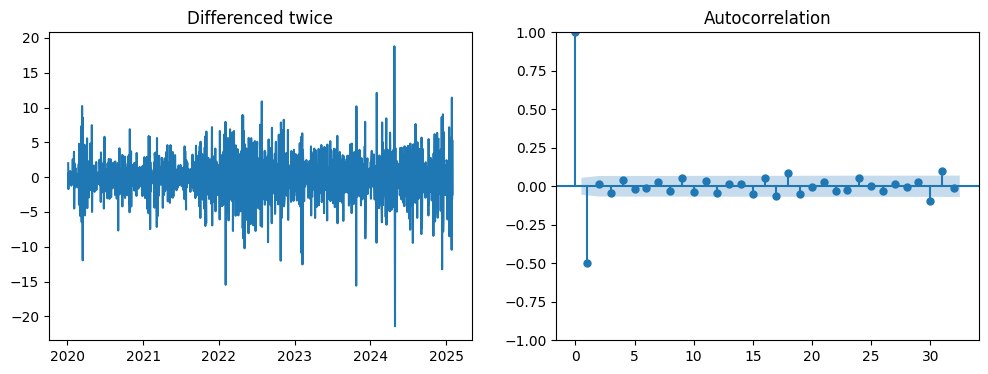

In [ ]:
diff = prices.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff,ax=ax2);

No bigger difference when differencing twice so selecting "order of differencing" as once and q = 8

p

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

(0.0, 1.0)

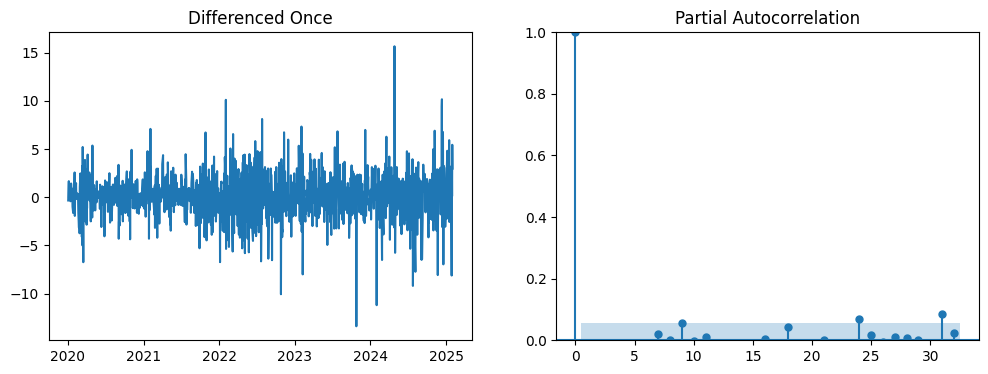

In [ ]:
#p

diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_pacf(diff,ax=ax2);
ax2.set_ylim(0,1)

We observe PACF lag 31 based on the plot

In [ ]:
# Compute returns
returns = prices.pct_change().dropna()

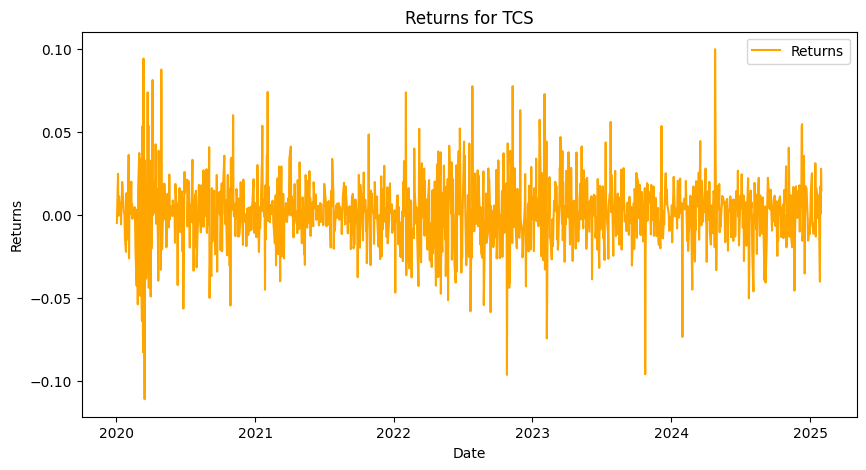

In [ ]:
# Plot returns
plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns, label='Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns for TCS')
plt.legend()
plt.show()


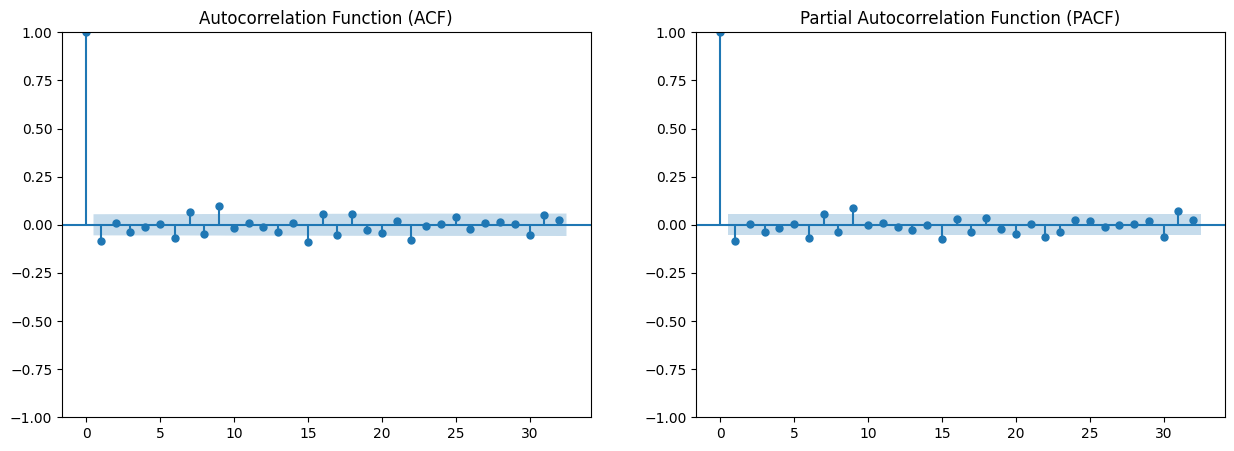

In [ ]:

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(returns, ax=axes[0])
plot_pacf(returns, method='ywm', ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
# Build ARIMA model (randomly chosen order, tuning required for better results)
model = ARIMA(prices, order=(11,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5147
Model:                ARIMA(11, 1, 1)   Log Likelihood               -8340.247
Date:                Thu, 03 Apr 2025   AIC                          16706.493
Time:                        07:54:28   BIC                          16791.591
Sample:                             0   HQIC                         16736.275
                               - 5147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      4.444     -0.002      0.999      -8.717       8.703
ar.L2         -0.0326      0.074     -0.438      0.662      -0.179       0.113
ar.L3         -0.0552      0.145     -0.382      0.7

In [ ]:
forecast = model_fit.get_forecast(steps=len(actual), alpha=0.05)
predicted_prices = forecast.predicted_mean
predicted_prices.reset_index().drop(columns=["index"])
predicted_dates = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=len(actual), freq='B')

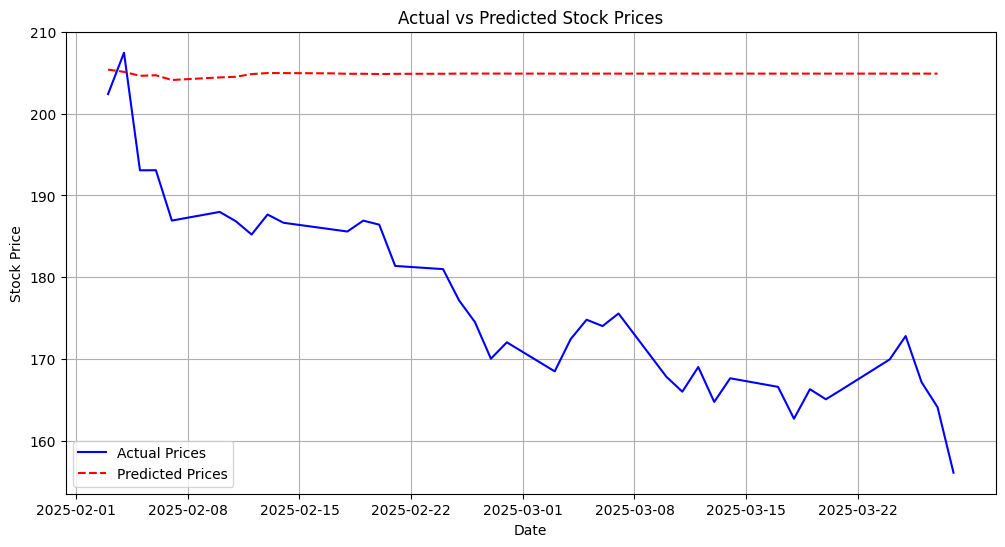

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')

# Plot predicted stock prices
plt.plot(predicted_dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:
len(actual['Close']),len(predicted_prices)

(39, 39)

 Calculating metrics

In [ ]:
r2_score(actual['Close'], predicted_prices)

-6.0584950649884135

In [ ]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 5815.486234209591
BIC: 6021.576988450893


In [ ]:

rmse = np.sqrt(mean_squared_error(actual['Close'], predicted_prices))
print(f"RMSE: {rmse:.4f}")

RMSE: 30.4701


### Auto Arima

In [ ]:
train_sf = prices.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

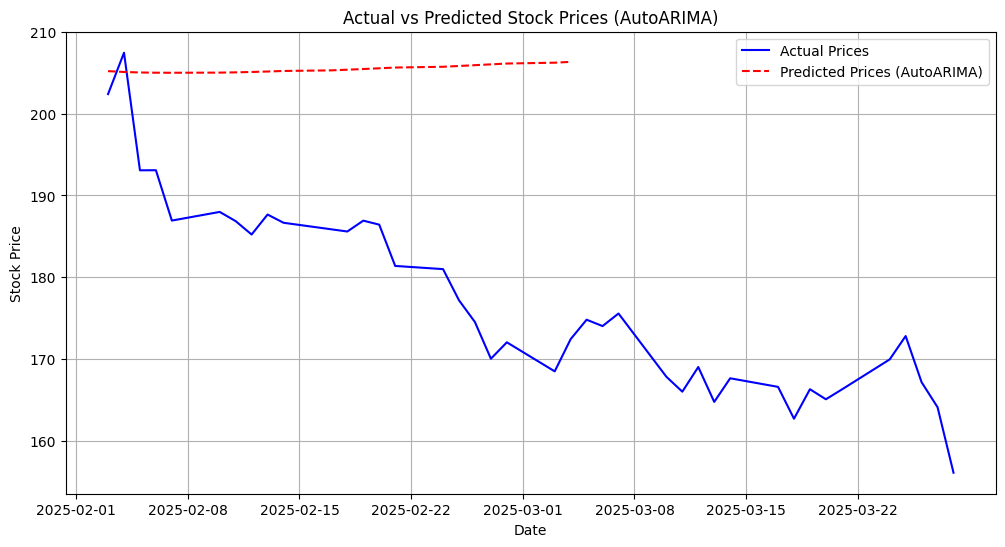

ValueError: Found input variables with inconsistent numbers of samples: [39, 22]

In [ ]:
# Prepare data for StatsForecast
train_sf = prices.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
train_sf['unique_id'] = 'GOOG'

# Initialize and fit AutoARIMA using StatsForecast
sf = StatsForecast(
    models=[AutoARIMA(season_length=90)], # You can adjust season_length as needed
    freq='B', # Business days frequency
)
sf.fit(train_sf)

# Generate forecast
forecast_sf = sf.predict(h=22)

# Extract predicted prices
predicted_prices_sf = forecast_sf['AutoARIMA'].values

# Create predicted dates
predicted_dates_sf = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=22, freq='B')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(predicted_dates_sf, predicted_prices_sf, label="Predicted Prices (AutoARIMA)", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (AutoARIMA)")
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
r2_sf = r2_score(actual['Close'], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

In [ ]:
# Calculate metrics
r2_sf = r2_score(actual['Close'].iloc[:22], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'].iloc[:22], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

R2 Score (AutoARIMA): -4.962892100130656
RMSE (AutoARIMA): 23.7362


In [ ]:
%%capture
!pip install statsforecast

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import warnings
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [ ]:

# Initialize and fit AutoARIMA using StatsForecast
sf = StatsForecast(
    models=[AutoARIMA(season_length=90)], # You can adjust season_length as needed
    freq='B', # Business days frequency
)
sf.fit(train_sf)

# Generate forecast
forecast_sf = sf.predict(h=22)

# Extract predicted prices
predicted_prices_sf = forecast_sf['AutoARIMA'].values

# Create predicted dates
predicted_dates_sf = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=22, freq='B')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(predicted_dates_sf, predicted_prices_sf, label="Predicted Prices (AutoARIMA)", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (AutoARIMA)")
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
r2_sf = r2_score(actual['Close'][:22], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'][:22], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

NameError: name 'train_sf' is not defined

In [ ]:
# Calculate metrics
r2_sf = r2_score(actual['Close'][:22], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'][:22], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

R2 Score (AutoARIMA): -4.979636682501852
RMSE (AutoARIMA): 23.7695


Arimax

In [ ]:
# prompt: filter from index 2020-01-01

df = GOOG[GOOG['Date'] >= '2020-01-01'].reset_index(drop=True)


,Close
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2025-01-27,193.549500
2025-01-28,196.845749
2025-01-29,196.955612


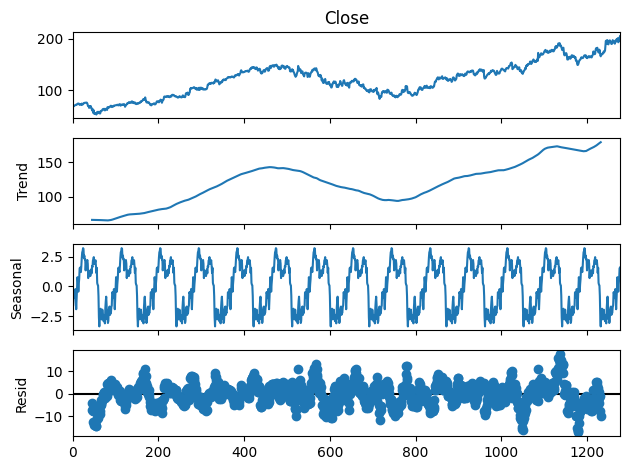

In [ ]:
five = GOOG[(GOOG['Date'] >= '2020-01-01')&(GOOG['Date'] <= '2025-01-31')].reset_index(drop=True)

from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(five['Close'], model='additive', period = 90)
decompose.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

#identifying p
x_acf = acf(five['Close'], nlags = 40)
# x_pacf = pacf(five['Close'], nlags=40)
x_acf

array([1.        , 0.9942376 , 0.98871535, 0.98369043, 0.97895462,
       0.97444079, 0.9695966 , 0.96496592, 0.96020089, 0.95540664,
       0.9504759 , 0.94577966, 0.94094849, 0.93671125, 0.93248036,
       0.92827496, 0.92414563, 0.91981324, 0.91557905, 0.9113655 ,
       0.90745772, 0.90364515, 0.89981095, 0.89599493, 0.89202605,
       0.88775619, 0.88344783, 0.87941327, 0.87550044, 0.87156124,
       0.86720812, 0.86306238, 0.85889611, 0.85446057, 0.84982532,
       0.84567657, 0.84171829, 0.83789194, 0.83415694, 0.83019489,
       0.8264667 ])

In [ ]:
len([1.        , 0.9942376 , 0.98871535, 0.98369043, 0.97895462,
       0.97444079, 0.9695966 , 0.96496592, 0.96020089, 0.95540664,
       0.9504759 ])

11

In [ ]:
x_pacf = pacf(five['Close'])
x_pacf

array([ 1.00000000e+00,  9.95016174e-01,  2.09066908e-02,  4.75658742e-02,
        2.87896211e-02,  2.37973321e-02, -3.18166425e-02,  2.06084860e-02,
       -1.69951375e-02, -5.50605048e-03, -1.85534405e-02,  2.11750002e-02,
       -1.92076756e-02,  5.99794859e-02, -3.21860818e-04,  8.01047028e-03,
        6.33769817e-03, -1.66642682e-02,  2.51794798e-03,  2.04507984e-03,
        2.64073282e-02,  9.20342954e-03, -1.44617115e-03,  4.09490410e-03,
       -1.72737766e-02, -3.17580780e-02, -8.13122447e-03,  2.06374539e-02,
        9.51879373e-03, -5.33316582e-03, -3.99844853e-02,  1.79691870e-02])

In [ ]:
%%capture
!pip install pmdarima
!pip install "numpy<2"

In [ ]:
five.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,68.046196,68.084512,66.761282,66.761282,28132000
1,2020-01-03,67.712273,68.301485,66.960037,67.075290,23728000
2,2020-01-06,69.381874,69.495829,67.181792,67.181792,34646000
3,2020-01-07,69.338585,69.818809,69.191280,69.567504,30054000
4,2020-01-08,69.884987,70.246275,69.214161,69.275865,30560000


In [ ]:
prices.head()

,Close
Date,
2020-01-02,68.046196
2020-01-03,67.712273
2020-01-06,69.381874
2020-01-07,69.338585
2020-01-08,69.884987


In [ ]:
tilljan = GOOG[(GOOG['Date'] <= '2025-01-31')]
tilljan.tail()

,Date,Close,High,Low,Open,Volume
5142,2025-01-27,193.549500,198.443917,192.480710,193.969020,24970200
5143,2025-01-28,196.845749,197.005555,192.390818,194.428489,15939200
5144,2025-01-29,196.955612,198.234170,194.967886,197.145398,12287800
5145,2025-01-30,202.399414,203.006724,199.245003,199.532670,14571500
5146,2025-01-31,205.366043,206.844355,203.348337,203.483178,17087300


In [ ]:

from pmdarima.arima import auto_arima

model = auto_arima(tilljan['Close'], seasonal=True, start_p=1, max_p=13, start_q=1, max_q=2, m=12, start_P= 0, trace=True, d = 1, D=1, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=11.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20433.513, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18588.876, Time=0.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=20435.455, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18085.184, Time=2.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18087.906, Time=1.72 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18085.301, Time=2.84 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=15.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=18084.982, Time=2.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=18588.813, Time=1.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=12.88 sec
 ARIMA(0,1,1)(1,1,1)[12]             

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5147
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood               -9037.238
Date:                             Fri, 04 Apr 2025   AIC                          18084.476
Time:                                     02:47:39   BIC                          18117.195
Sample:                                          0   HQIC                         18095.928
                                            - 5147                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0337      0.006     -5.248      0.000      -0.046      -0.021
ma.L2         -0.0224      0.008     -2.891      0.004      -0.038      -0.007
ar.S.L12      -0.7241      0.006   -120.450      0.000      -0.736      -0.712
ar.S.L24      -0.3130      0.006    -51.797      0.000      -0.325      -0.301
sigma2         1.9765      0.014    144.525      0.000       1.950       2.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             46264.27
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              78.81   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
%%capture
model.predict(n_periods=22)

In [ ]:
forecast = model.predict(n_periods=22)
predicted_prices = forecast
# predicted_prices.reset_index().drop(columns=["index"])
predicted_dates = pd.date_range(start=tilljan['Date'].iloc[-1]+ pd.Timedelta(days=1), periods=22, freq='B')

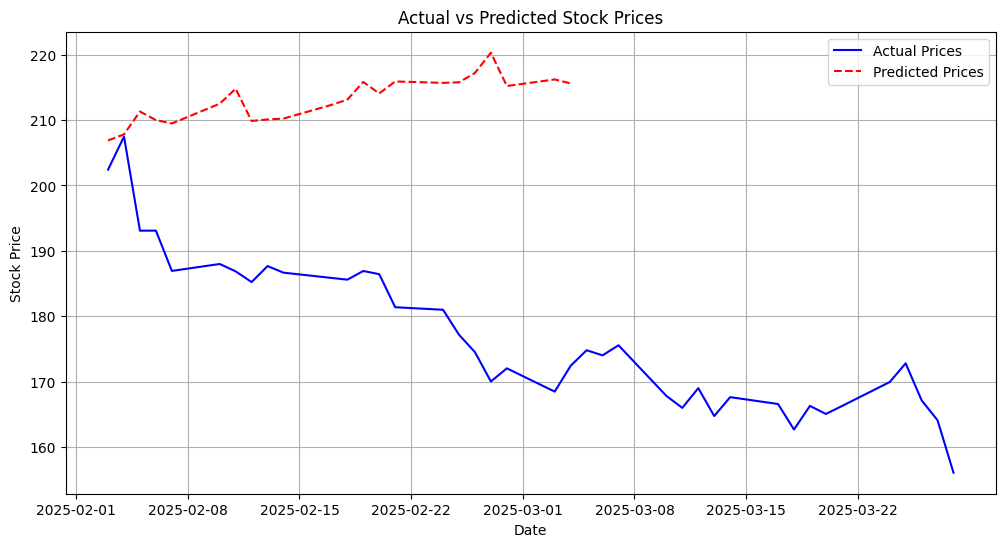

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')

# Plot predicted stock prices
plt.plot(predicted_dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:

rmse = np.sqrt(mean_squared_error(actual['Close'].iloc[:22], predicted_prices))
print(f"RMSE: {rmse:.4f}")

RMSE: 31.8670


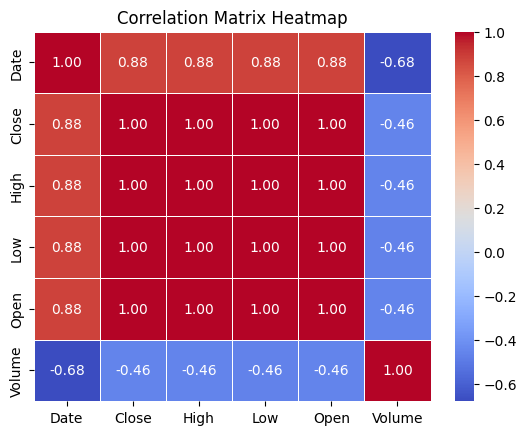

In [ ]:
# prompt: create a corelation matrix for df
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
df

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512
...,...,...,...,...,...,...
5181,2025-03-24,169.929993,170.500000,167.440002,169.264999,18742800
5182,2025-03-25,172.789993,172.910004,170.550003,171.179993,13841600
5183,2025-03-26,167.139999,171.940002,166.860992,171.300003,22554200
5184,2025-03-27,164.080002,167.440002,163.850006,166.710007,21571200


### LSTM

In [13]:
GOOG

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512
...,...,...,...,...,...,...
5181,2025-03-24,169.929993,170.500000,167.440002,169.264999,18742800
5182,2025-03-25,172.789993,172.910004,170.550003,171.179993,13841600
5183,2025-03-26,167.139999,171.940002,166.860992,171.300003,22554200
5184,2025-03-27,164.080002,167.440002,163.850006,166.710007,21571200


In [14]:
temp = GOOG
temp.set_index("Date", inplace=True)
temp.head()

,Close,High,Low,Open,Volume
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [15]:
features_to_use = ['Open', 'High', 'Low', 'Volume']
target_col = 'Close'

# Select final data
all_cols = features_to_use + ([target_col] if target_col not in features_to_use else [])
data_final = temp[all_cols].copy()

print("Data head with features:")
print(data_final.head())

Data head with features:
                Open      High       Low     Volume     Close
Date                                                         
2004-08-19  2.478923  2.579567  2.378775  897427216  2.487352
2004-08-20  2.503960  2.704009  2.491318  458857488  2.684922
2004-08-23  2.745407  2.813082  2.703266  366857939  2.711942
2004-08-24  2.757554  2.766478  2.567421  306396159  2.599647
2004-08-25  2.601877  2.677237  2.575105  184645512  2.627658


In [16]:
# Scale features and target separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [17]:
# Sort data by date just in case it's not
data_final.sort_index(inplace=True)

scaled_features = feature_scaler.fit_transform(data_final[features_to_use])

# Scale target
# Reshape target to be 2D array for scaler
scaled_target = target_scaler.fit_transform(data_final[[target_col]])

In [18]:
def create_dataset(X_data, y_data, time_step=60):
    Xs, ys = [], []
    # We need data up to index i + time_step for y, so loop ends earlier
    for i in range(len(X_data) - time_step):
        v = X_data[i:(i + time_step)]
        Xs.append(v)
        ys.append(y_data[i + time_step]) # Predict the day *after* the sequence ends
    return np.array(Xs), np.array(ys)

TIME_STEP = 60 # Lookback window
X, y = create_dataset(scaled_features, scaled_target, TIME_STEP)


In [19]:
# Define the split date for Train/Test
split_date_str = "2025-01-31" # Data *before* this is train, *on or after* is test
split_date = pd.to_datetime(split_date_str)
split_date

Timestamp('2025-01-31 00:00:00')

In [20]:
original_indices_for_y = data_final.index[TIME_STEP:]
original_indices_for_y

DatetimeIndex(['2004-11-12', '2004-11-15', '2004-11-16', '2004-11-17',
               '2004-11-18', '2004-11-19', '2004-11-22', '2004-11-23',
               '2004-11-24', '2004-11-26',
               ...
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
               '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26',
               '2025-03-27', '2025-03-28'],
              dtype='datetime64[ns]', name='Date', length=5126, freq=None)

In [21]:
split_point_sequences = np.where(original_indices_for_y >= split_date)[0][0]


In [22]:
np.where(original_indices_for_y >= split_date)

(array([5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096,
        5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107,
        5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118,
        5119, 5120, 5121, 5122, 5123, 5124, 5125]),)

In [23]:
validation_split_fraction = 0.15 # Use 15% of the data *before* the test split for validation
val_size = int(split_point_sequences * validation_split_fraction)

# if val_size == 0 and split_point_sequences > 1 : # Ensure val_size is at least 1 if possible
#     val_size = 1

train_size = split_point_sequences - val_size


In [24]:
split_point_sequences

np.int64(5086)

In [25]:
# Perform the splits
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:split_point_sequences], y[train_size:split_point_sequences]
X_test, y_test = X[split_point_sequences:], y[split_point_sequences:]
# Keep track of the actual dates for the test set targets for comparison later
test_dates = original_indices_for_y[split_point_sequences:]

In [26]:
# split_ratio = 0.5

# X_val_1, X_val_2, y_val_1, y_val_2 = train_test_split(
#     X_val, y_val, test_size=split_ratio, random_state=42  # Set a random_state for reproducibility
# )

In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4324, 60, 4), (4324, 1), (762, 60, 4), (762, 1), (40, 60, 4), (40, 1))

In [50]:
# --- 5. Model Building Function for Keras Tuner ---
def build_model(hp):
    model = Sequential()

    # Tune the number of LSTM units in the first layer
    # Choose a range (e.g., 32-256 units), step size 32
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=hp_units_1, return_sequences=True, # return_sequences=True if next layer is LSTM
                    input_shape=(X_train.shape[1], X_train.shape[2]))) # (time_steps, num_features)
    # Tune dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))

    # --- Optional: Add more LSTM layers ---
    # Tune whether to have a second LSTM layer
    if hp.Boolean("add_second_lstm_layer"):
        hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
        # return_sequences=False if the next layer is Dense
        model.add(LSTM(units=hp_units_2, return_sequences=False))
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(hp_dropout_2))
    else:
        # If only one LSTM layer, make sure it doesn't return sequences
        # We need to rebuild the first layer definition slightly differently
        model = Sequential() # Start over for simplicity in this example structure
        model.add(LSTM(units=hp_units_1, return_sequences=False, # Set to False now
                         input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(hp_dropout_1))
    # --- End Optional Section ---


    # Output layer
    model.add(Dense(units=1)) # Predicting one value

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error', # Common for regression
                  metrics=['mean_absolute_error']) # Easier to interpret than MSE
    return model

try:
  url = 'https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/bestparam.json'
  response = requests.get(url)
  response.raise_for_status()
  best_hps = response.json()
except:
  # --- 6. Instantiate the Tuner ---
  # Hyperband is an efficient tuner
  tuner = kt.Hyperband(build_model,
                      objective='val_mean_absolute_error', # Minimize validation MAE
                      max_epochs=50, # Max epochs *per trial* in Hyperband
                      factor=3, # Reduction factor for candidates per bracket
                      directory='keras_tuner_dir', # Directory to store results
                      project_name='googl_stock_lstm',
                      overwrite=False) # Set overwrite to False to resume

  # Optional: Add EarlyStopping callback *during tuning*
  # This stops training a specific trial early if validation loss doesn't improve
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # --- 7. Run the Hyperparameter Search (Conditional Execution) ---
  search_already_run = os.path.exists(os.path.join('keras_tuner_dir', 'googl_stock_lstm', 'project.json'))

  if not search_already_run:
      print("\nStarting hyperparameter search...")
      # Note: Use validation data here for the tuner to evaluate configurations
      # The number of epochs here is the max per trial for Hyperband internal loops
      tuner.search(X_train, y_train,
                  epochs=50, # This refers to max_epochs for Hyperband trials
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping],
                  batch_size=32) # You can also tune batch_size if desired
  else:
      print("\nHyperparameter search already completed or found existing results.")
      print("Loading previous search results...")
      try:
          best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

          print(f"""
          The hyperparameter search is complete.
          Optimal number of units in first LSTM layer: {best_hps.get('units_1')}
          Optimal dropout rate for first layer: {best_hps.get('dropout_1')}
          Optimal learning rate: {best_hps.get('learning_rate')}
          Include second LSTM layer: {best_hps.get('add_second_lstm_layer')}
          """)

          if best_hps.get('add_second_lstm_layer'):
              print(f"Optimal number of units in second LSTM layer: {best_hps.get('units_2')}")
              print(f"Optimal dropout rate for second layer: {best_hps.get('dropout_2')}")
      except Exception as e:
          print(f"Error loading previous results: {e}")
          print("Please ensure the 'keras_tuner_dir/googl_stock_lstm' directory exists and contains valid tuner data.")
          print("You might need to run the search again if the previous run was incomplete or corrupted.")

  # --- 8. Get the Optimal Hyperparameters ---
  if not search_already_run:
      best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

      print(f"""
      The hyperparameter search is complete.
      Optimal number of units in first LSTM layer: {best_hps.get('units_1')}
      Optimal dropout rate for first layer: {best_hps.get('dropout_1')}
      Optimal learning rate: {best_hps.get('learning_rate')}
      Include second LSTM layer: {best_hps.get('add_second_lstm_layer')}
      """)

      if best_hps.get('add_second_lstm_layer'):
          print(f"Optimal number of units in second LSTM layer: {best_hps.get('units_2')}")
          print(f"Optimal dropout rate for second layer: {best_hps.get('dropout_2')}")

In [46]:
# # best model values stored as file

# import json

# with open("bestparam.json", 'w') as f:
#         json.dump(best_hps.values, f, indent=4)

In [31]:
# Extract the values into a dictionary
best_params = {
    'units_1': best_hps.get('units_1'),
    'dropout_1': best_hps.get('dropout_1'),
    'learning_rate': best_hps.get('learning_rate'),
    'add_second_lstm_layer': best_hps.get('add_second_lstm_layer'),
    # Add other tuned parameters here...
}
if best_params['add_second_lstm_layer']:
     best_params['units_2'] = best_hps.get('units_2')
     best_params['dropout_2'] = best_hps.get('dropout_2')

print("\nBest Hyperparameters Found:")
print(best_params)


Best Hyperparameters Found:
{'units_1': 160, 'dropout_1': 0.2, 'learning_rate': 0.01, 'add_second_lstm_layer': False}


In [32]:
# --- 9. Build and Train the Final Model ---
# Build the model with the optimal hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model on the full training data (train + validation)
# You might want to retrain for a potentially different number of epochs
# based on observing the tuner's best trial or using early stopping again.
print("\nTraining the best model...")
# Combine train and validation sets for final training
X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

# Use early stopping for the final training run
final_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Longer patience maybe

# Determine appropriate epochs: You can use a fixed large number and rely on EarlyStopping
# The 'best' number of epochs is often found implicitly by EarlyStopping.
history = final_model.fit(X_train_full, y_train_full,
                          epochs=100, # Train for potentially more epochs, let EarlyStopping decide
                          batch_size=32, # Use a fixed batch size or the one found by tuner if tuned
                          validation_data=(X_test, y_test), # Evaluate on the *test* set here for final performance check
                                                            # Ideally, have a separate validation set for EarlyStopping during final training if not using test set
                          callbacks=[final_early_stopping])

print("\nBest model training complete.")
best_epoch = final_early_stopping.stopped_epoch  # This gives the epoch number where stopping occurred
print(f"Training stopped after epoch: {best_epoch + 1} (due to EarlyStopping)") # +1 because epochs are 0-indexed internally

# --- 10. Evaluate on Test Set ---
test_loss, test_mae = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Set Evaluation:")
print(f"  Mean Squared Error (MSE): {test_loss}")
print(f"  Mean Absolute Error (MAE): {test_mae}")

# To make actual price predictions, you need to inverse_transform the scaled predictions
predictions_scaled = final_model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# You can then calculate MAE, RMSE etc. on the actual price scale
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_actual = mean_absolute_error(y_test_actual, predictions)
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"\nTest Set Performance (Actual Price Scale):")
print(f"  Mean Absolute Error (MAE): ${mae_actual:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse_actual:.2f}")


Training the best model...
Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0169 - mean_absolute_error: 0.0595 - val_loss: 7.9218e-04 - val_mean_absolute_error: 0.0218
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.1010e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5887e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0019 - val_mean_absolute_error: 0.0375
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9397e-04 - mean_absolute_error: 0.0127 - val_loss: 6.1951e-04 - val_mean_absolute_error: 0.0204
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0779e-04 - mean_absolute_error: 0.0112 - val_loss: 6.1435e-04 - val_mean_absolute_error: 0.0200
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9610e-04 - mean_absolute_error: 0.0110 - val_loss: 6.1948e-04 - val_mean_absolute_error: 0.0200
Epoch 7/100
159/159 ━━━━━━━━━━

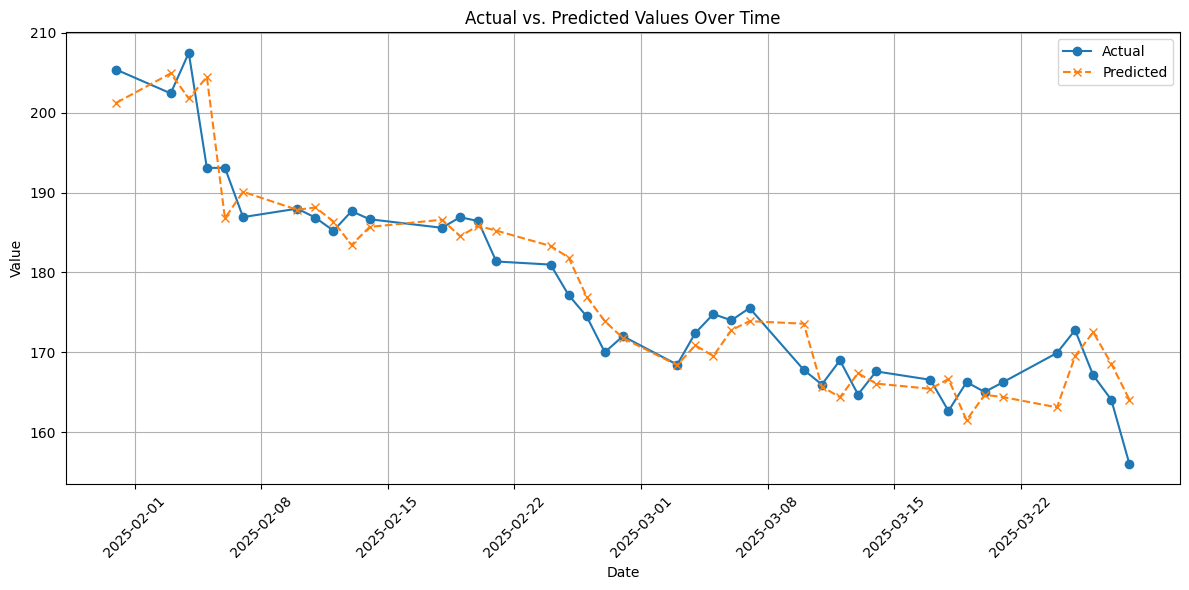

In [44]:
plot_dates = original_indices_for_y[-len(predictions):]
actual_values = y_test_actual
predicted_values = predictions

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, actual_values, label='Actual', marker='o', linestyle='-')
plt.plot(plot_dates, predicted_values, label='Predicted', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### SARIMA

In [ ]:
0,1,2)(2,1,0)[12]

In [36]:
training_data = list(prices['Close'])

In [ ]:
for i in range(len(actual)):
  model = ARIMA(training_data, order=(11,1,1), seasonal_order=(2,1,0,12))
  model_fit = model.fit()
  forecast = model_fit.forecast()
  yhat = list(forecast)[0]
  modelpredictions.append(yhat)
  actual_test = list(actual['Close'])[i]
  training_data.append(actual_test)

In [ ]:
print(model_fit.summary())

In [ ]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### ARIMAX

### SARIMAX

### Prophet

### SVM

In [12]:
# Define features and target
features = ['High', 'Low', 'Open', 'Volume']  # Try adding SMA_50, EMA_50 later
target = 'Close'

# Split the data into training (80%) and testing (20%) sets
train, test = df,actual

# Standardize the predictors
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Adjusted hyperparameter grid to prevent overfitting
param_grid = {
    'C': [0.01, 0.1],  # Reduce regularization to avoid overfitting
    'epsilon': [0.1, 0.2],  # Increase epsilon to prevent capturing noise
    'gamma': ['scale'],  # Keep gamma 'scale' to avoid extreme non-linearity
    'kernel': ['linear']  # Linear kernel generalizes better
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train_scaled, train[target])

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the SVR model with the best parameters
svm_model = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_model.fit(train_scaled, train[target])

# Predict on the training and testing sets
test_preds = svm_model.predict(test_scaled)

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Training R-squared: 0.9988
Testing R-squared: 0.9756
Training MSE: 1.4061
Testing MSE: 3.2125


In [17]:

# Calculate R-squared and Mean Squared Error (MSE)
train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)

train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


Training R-squared: 0.9988
Testing R-squared: 0.9756
Training MSE: 1.4061
Testing MSE: 3.2125


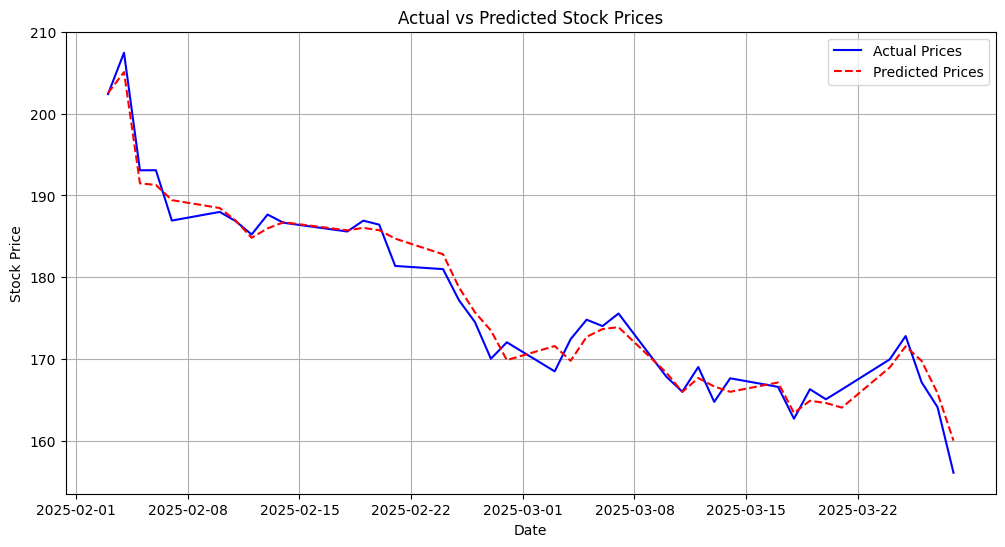

In [16]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], test_preds, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)
train, test = df,actual
predictors = ["Close", "Volume", "Open", "High", "Low"]

model.fit(train[predictors], train["Close"])
preds = model.predict(test[predictors])

In [29]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

train, test = df,actual
model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)
predictors = ["Close", "Volume", "Open", "High", "Low"]
predictions = []

for i in range(len(test)):

    # Retrain the model with the updated training data
    model.fit(train[predictors], train["Close"])

    # Predict the next value
    next_pred = model.predict(test.iloc[[i]][predictors])[0]
    predictions.append(next_pred)

    # Create a new row with the predicted value and the corresponding test data
    new_row = test.iloc[[i]].copy()
    new_row['Close'] = next_pred

    # Add the new row to the training data
    train = pd.concat([train, new_row], ignore_index=True)

print("Predictions:", predictions)

Predictions: [np.float64(190.356822306355), np.float64(190.36809642673836), np.float64(190.39660940421462), np.float64(190.42207377295682), np.float64(190.46138283917216), np.float64(190.50446164483517), np.float64(190.52508843855628), np.float64(190.58212156975117), np.float64(190.64173410875512), np.float64(190.6879349416188), np.float64(190.7169687813036), np.float64(190.75630410884673), np.float64(190.75862204898812), np.float64(190.7745978310483), np.float64(188.54462501568278), np.float64(169.8062502476869), np.float64(168.7740732088301), np.float64(168.830853579859), np.float64(168.82423315518125), np.float64(168.68974062958114), np.float64(168.96799098168202), np.float64(169.13888243840313), np.float64(169.20627938204788), np.float64(169.57919521678815), np.float64(168.2918692829286), np.float64(167.6399169712981), np.float64(168.6250842211683), np.float64(167.41083157485573), np.float64(168.20971199209814), np.float64(167.5248401043674), np.float64(166.99010167125246), np.floa

In [33]:
# Calculate R-squared and Mean Squared Error (MSE)
test_r2 = r2_score(test[target], predictions)

test_mse = mean_squared_error(test[target], predictions)

print(f"Testing R-squared: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R-squared: 0.8085
Testing MSE: 25.1943


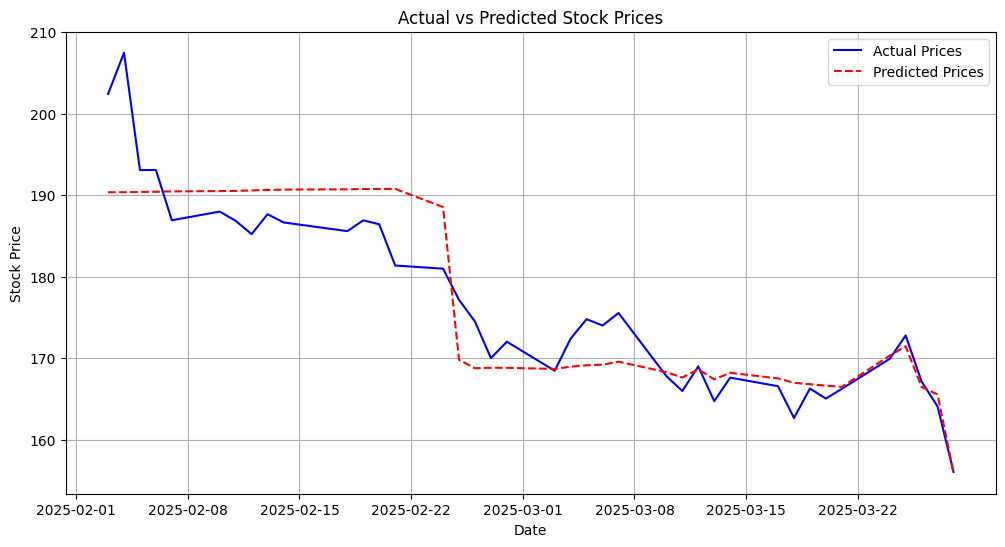

In [31]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], predictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

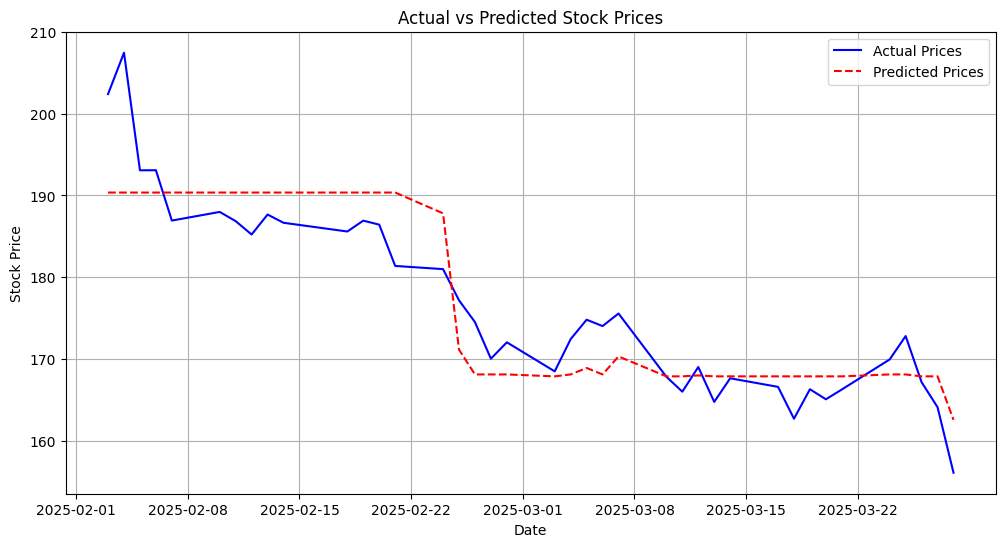

In [28]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], preds, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()